In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [45]:
df = pd.read_csv('wifi_localization.txt', sep='\t', header=None)

In [46]:
df[7] = df[7] - 1

In [18]:
df.head()

,0,1,2,3,4,5,6,7
0,-64,-56,-61,-66,-71,-82,-81,0
1,-68,-57,-61,-65,-71,-85,-85,0
2,-63,-60,-60,-67,-76,-85,-84,0
3,-61,-60,-68,-62,-77,-90,-80,0
4,-63,-65,-60,-63,-77,-81,-87,0


In [19]:
df.describe()

,0,1,2,3,4,5,6,7
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-52.330500,-55.623500,-54.964000,-53.566500,-62.640500,-80.985000,-81.726500,1.500000
std,11.321677,3.417688,5.316186,11.471982,9.105093,6.516672,6.519812,1.118314
min,-74.000000,-74.000000,-73.000000,-77.000000,-89.000000,-97.000000,-98.000000,0.000000
25%,-61.000000,-58.000000,-58.000000,-63.000000,-69.000000,-86.000000,-87.000000,0.750000
50%,-55.000000,-56.000000,-55.000000,-56.000000,-64.000000,-82.000000,-83.000000,1.500000
75%,-46.000000,-53.000000,-51.000000,-46.000000,-56.000000,-77.000000,-78.000000,2.250000
max,-10.000000,-45.000000,-40.000000,-11.000000,-36.000000,-61.000000,-63.000000,3.000000


In [47]:
training_data, test_data = train_test_split(df, train_size=.8, random_state=42)

In [48]:
x_train = training_data[[0,1,2,3,4,5,6]].values
y_train = training_data[[7]].values
x_test = test_data[[0,1,2,3,4,5,6]].values
y_test = test_data[[7]].values

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model, x_train, y_train,x_test,y_test, epochs=300):
    print('Fitting model...')
    sk_model.fit(x_train, y_train.reshape(y_train.shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(x_train, label=y_train)
    val = xgb.DMatrix(x_test, label=y_test)
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(x_test), y_test)))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(x_test),y_test,average='micro')))
    print('XGBoost Confusion Matrix:\n', confusion_matrix(sk_model.predict(x_test),y_test))
    plot_compare(metrics,store,epochs)
    features = np.arange(0, 7)
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

In [50]:
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
#initial model
xgb1 = XGBClassifier(n_estimators=1000,
                     objective='multi:softmax',
                    num_class=4,
                    seed=42)

Fitting model...
Fitting done!
[0]	val-mlogloss:1.21367	val-merror:0.04	train-mlogloss:1.20971	train-merror:0.023125
[100]	val-mlogloss:0.065353	val-merror:0.0175	train-mlogloss:0.012176	train-merror:0.00125
[200]	val-mlogloss:0.072659	val-merror:0.0175	train-mlogloss:0.004946	train-merror:0
[299]	val-mlogloss:0.075207	val-merror:0.0175	train-mlogloss:0.003213	train-merror:0
-- Model Report --
XGBoost Accuracy: 0.9825
XGBoost F1-Score (Micro): 0.9825
XGBoost Confusion Matrix:
 [[103   0   0   1]
 [  0  90   0   0]
 [  0   5  88   0]
 [  1   0   0 112]]


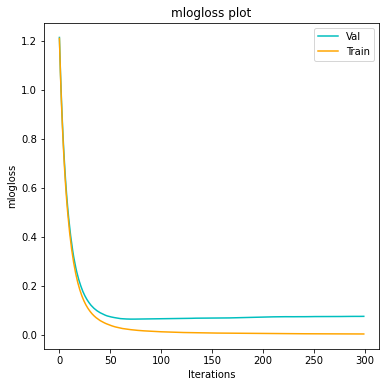

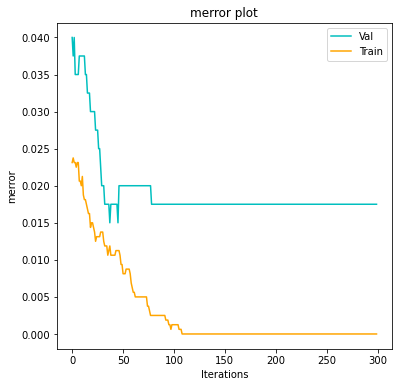

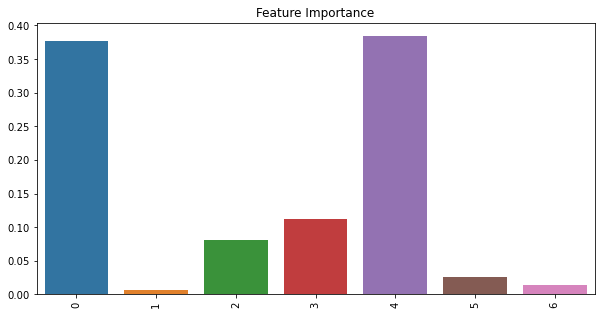

In [51]:
fitXgb(xgb1, x_train, y_train,x_test,y_test)

In [29]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [55]:
param_test = {
    'learning_rate':[1e-3, 1e-2, 1e-1],
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,6,1),
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch = GridSearchCV(estimator = xgb1, param_grid = param_test, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch.fit(x_train, y_train)

Fitting 5 folds for each of 525 candidates, totalling 2625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

GridSearchCV(cv=5,
             estimator=XGBClassifier(n_estimators=1000, num_class=4,
                                     objective='multi:softprob', seed=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(3, 10),
                         'min_child_weight': range(1, 6),
                         'reg_alpha': [1e-05, 0.01, 0.1, 1, 10]},
             scoring='f1_micro', verbose=10)

In [56]:
getTrainScores(gsearch)

({0: "mean:0.9737500000000001params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 1e-05}",
  1: "mean:0.9737500000000001params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.01}",
  2: "mean:0.9737499999999999params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.1}",
  3: "mean:0.9737499999999999params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 1}",
  4: "mean:0.9675params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 10}",
  5: "mean:0.974375params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 1e-05}",
  6: "mean:0.974375params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0.01}",
  7: "mean:0.975params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0.1}",
  8: "mean:0.9743749999999999params{'learning_rate': 0.001, 'max_depth': 3, 'min_child_wei

Fitting model...
Fitting done!
[0]	val-mlogloss:1.20703	val-merror:0.0325	train-mlogloss:1.20205	train-merror:0.010625
[100]	val-mlogloss:0.066644	val-merror:0.015	train-mlogloss:0.004024	train-merror:0
[200]	val-mlogloss:0.069708	val-merror:0.0125	train-mlogloss:0.002368	train-merror:0
[299]	val-mlogloss:0.070808	val-merror:0.0125	train-mlogloss:0.002054	train-merror:0
-- Model Report --
XGBoost Accuracy: 0.9875
XGBoost F1-Score (Micro): 0.9875
XGBoost Confusion Matrix:
 [[104   0   0   1]
 [  0  91   0   0]
 [  0   4  88   0]
 [  0   0   0 112]]


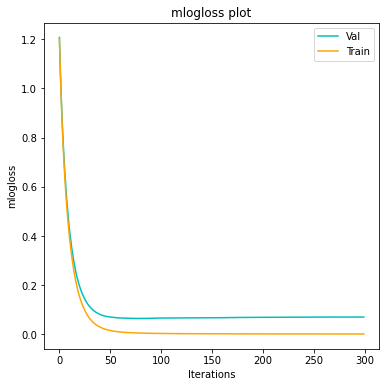

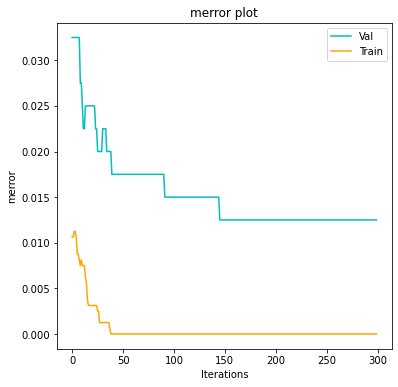

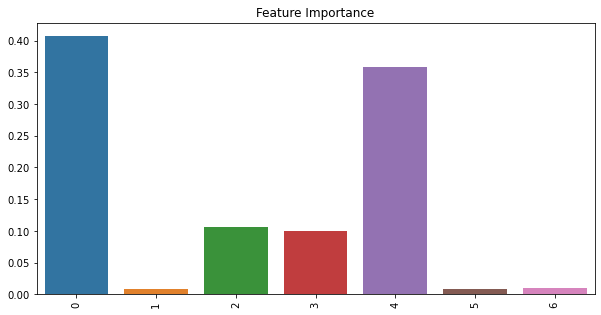

In [67]:
xgb2 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=1,
    reg_alpha=1e-3,
    objective='multi:softmax',
    num_class=4,
    seed=42)

fitXgb(xgb2, x_train,y_train,x_test,y_test)
